## Import Packages

In [50]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## Network Data

In [51]:
buses = {
    'Bus1': {'type': 'generator'}, 'Bus2': {'type': 'generator'},
    'Bus3': {'type': 'generator'}, 'Bus4': {'type': 'generator'},
    'Bus5': {'type': 'load'}, 'Bus6': {'type': 'generator'},
    'Bus7': {'type': 'load'}, 'Bus8': {'type': 'load'},
}

generators = {
    'Gen1': {'bus': 'Bus1', 'capacity': 300, 'cost': 20},
    'Gen2': {'bus': 'Bus2', 'capacity': 150, 'cost': 10},
    'Gen3': {'bus': 'Bus3', 'capacity': 600, 'cost': 30},
    'Gen4': {'bus': 'Bus4', 'capacity': 0, 'cost': 0},
    'Gen5': {'bus': 'Bus6', 'capacity': 0, 'cost': 0},
}

base_loads = {
    'Load5': {'bus': 'Bus5', 'demand': 80},
    'Load7': {'bus': 'Bus7', 'demand': 120},
    'Load8': {'bus': 'Bus8', 'demand': 150},
}

lines = {
    ('Bus1', 'Bus4'): {'capacity': 50}, ('Bus1', 'Bus2'): {'capacity': 50},
    ('Bus2', 'Bus3'): {'capacity': 70}, ('Bus2', 'Bus5'): {'capacity': 50},
    ('Bus3', 'Bus6'): {'capacity': 90}, ('Bus4', 'Bus7'): {'capacity': 80},
    ('Bus5', 'Bus7'): {'capacity': 70}, ('Bus5', 'Bus6'): {'capacity': 65},
    ('Bus6', 'Bus8'): {'capacity': 50}, ('Bus7', 'Bus8'): {'capacity': 30},
}
reactance = {
    ('Bus1', 'Bus4'): 0.18,
    ('Bus1', 'Bus2'): 0.11,
    ('Bus2', 'Bus3'): 0.27,
    ('Bus2', 'Bus5'): 0.09,
    ('Bus3', 'Bus6'): 0.22,
    ('Bus4', 'Bus7'): 0.15,
    ('Bus5', 'Bus7'): 0.13,
    ('Bus5', 'Bus6'): 0.19,
    ('Bus6', 'Bus8'): 0.24,
    ('Bus7', 'Bus8'): 0.08,
}

line_upgrade_cost = 5
yearly_upgrade_budget = 500
VOLL = 100

## Scenario Tree Generation

**Key Concept:** Each "path" represents a sequence of realized demand scenarios.
- Year 1: 3 paths (baseline, high, low)
- Year 2: 9 paths (each year-1 path branches into 3)
- Year t: 3^t paths

**Demand Structure:**
- Demand in year t = Demand in year (t-1) × growth_factor[t] × scenario_multiplier[t]

In [52]:
# Demand growth scenarios
scenario_types = ['high', 'low']
scenario_probabilities = {'high': 0.6, 'low': 0.4}
scenario_multipliers = {'high': 1.1, 'low': 0.9}

# Planning horizon (limited due to exponential growth)
PLANNING_YEARS = 10  # 2^10 = 1,024 paths (manageable)
years = range(1, PLANNING_YEARS + 1)

print(f"Planning horizon: {PLANNING_YEARS} years")
print(f"Total terminal paths: 2^{PLANNING_YEARS} = {2**PLANNING_YEARS:,}")

Planning horizon: 10 years
Total terminal paths: 2^10 = 1,024


In [53]:
def build_scenario_tree(max_year):
    """
    Build scenario tree with path-dependent demand.
    A path is a tuple like ('high', 'low') representing scenario realizations.
    """
    # Scenario paths by year
    paths_by_year = {1: [('high',), ('low',)]}
    
    # Path probabilities
    path_prob = {}
    for path in paths_by_year[1]:
        path_prob[(1, path)] = scenario_probabilities[path[0]]
    
    # Demand: starts from base demand in year 1
    demand = {}
    for load, load_data in base_loads.items():
        base_demand = load_data['demand']
        for path in paths_by_year[1]:
            s = path[0]
            demand[(load, 1, path)] = base_demand * scenario_multipliers[s]
    
    # Build tree for years 2 onwards
    for y in range(2, max_year + 1):
        paths_by_year[y] = []
        
        for prev_path in paths_by_year[y - 1]:
            for s in scenario_types:
                new_path = prev_path + (s,)
                paths_by_year[y].append(new_path)
                
                # Path probability
                path_prob[(y, new_path)] = path_prob[(y - 1, prev_path)] * scenario_probabilities[s]
                
                # Path-dependent demand: previous demand × growth × scenario
                for load in base_loads.keys():
                    prev_demand = demand[(load, y - 1, prev_path)]
                    demand[(load, y, new_path)] = prev_demand * scenario_multipliers[s]
    
    return paths_by_year, path_prob, demand

print("Building scenario tree...")
paths_by_year, path_prob, demand = build_scenario_tree(PLANNING_YEARS)

print("\nScenario tree structure:")
for y in years:
    print(f"  Year {y}: {len(paths_by_year[y]):,} paths")

# Show example path evolution
print("\nExample: Demand for Load5 along path ('high', 'high', 'high'):")
for y in range(1, min(4, PLANNING_YEARS + 1)):
    example_path = tuple(['high'] * y)
    dem = demand[('Load5', y, example_path)]
    prob = path_prob[(y, example_path)]
    print(f"  Year {y}: {dem:.2f} MW (prob = {prob:.4f})")

Building scenario tree...

Scenario tree structure:
  Year 1: 2 paths
  Year 2: 4 paths
  Year 3: 8 paths
  Year 4: 16 paths
  Year 5: 32 paths
  Year 6: 64 paths
  Year 7: 128 paths
  Year 8: 256 paths
  Year 9: 512 paths
  Year 10: 1,024 paths

Example: Demand for Load5 along path ('high', 'high', 'high'):
  Year 1: 88.00 MW (prob = 0.6000)
  Year 2: 96.80 MW (prob = 0.3600)
  Year 3: 106.48 MW (prob = 0.2160)


## Build Multi-Stage Optimization Model

**Decision Structure:**
- Investment at year t depends only on path history up to year t-1
- Non-anticipativity: paths with same history make same investment decision
- Operations depend on full path (including year t realization)

In [54]:
model = gp.Model("Multistage_Stochastic_Sequential")

print("Creating variables...")

# ========================================
# INVESTMENT VARIABLES (by path history)
# ========================================
# For year t, investment decision depends on path history up to year t-1
line_upgrade_vars = {}

for y in years:
    # Get all paths at year y
    for path in paths_by_year[y]:
        for (bus_from, bus_to) in lines.keys():
            # Investment decision at start of year y
            # Key: (line, year, path_history)
            # For year 1, path_history is empty; for year t>1, it's path[:-1]
            line_upgrade_vars[(bus_from, bus_to, y, path)] = model.addVar(
                lb=0,
                name=f"Upgrade_{bus_from}_{bus_to}_Y{y}_P{path}"
            )
#=========================================
# Voltage angles
#=========================================
theta = {}

for y in years:
    for path in paths_by_year[y]:
        for bus in buses.keys():
            theta[(bus, y, path)] = model.addVar(
                lb=-GRB.INFINITY,
                name=f"Theta_{bus}_Y{y}_P{path}"
            )

# Slack bus: θ = 0 for all (year, path)
slack_bus = "Bus1"
for y in years:
    for path in paths_by_year[y]:
        model.addConstr(
            theta[(slack_bus, y, path)] == 0,
            name=f"Slack_{slack_bus}_Y{y}_P{path}"
        )


# ========================================
# OPERATIONAL VARIABLES (by full path)
# ========================================
gen_vars = {}
line_vars = {}
shed_vars = {}

for y in years:
    for path in paths_by_year[y]:
        # Generation
        for gen, gen_data in generators.items():
            gen_vars[(gen, y, path)] = model.addVar(
                lb=0, ub=gen_data['capacity'],
                name=f"Gen_{gen}_Y{y}_P{path}"
            )
        
        # Line flows
        for (bus_from, bus_to) in lines.keys():
            line_vars[(bus_from, bus_to, y, path)] = model.addVar(
                lb=-GRB.INFINITY,
                name=f"Flow_{bus_from}_{bus_to}_Y{y}_P{path}"
            )
        
        # Load shedding
        for load in base_loads.keys():
            shed_vars[(load, y, path)] = model.addVar(
                lb=0,
                name=f"Shed_{load}_Y{y}_P{path}"
            )

model.update()
print(f"Variables created: {model.NumVars:,}")

Creating variables...
Variables created: 73,656


In [55]:
print("Adding constraints...")
for key in lines:
    lines[key]['reactance'] = reactance[key]


for (bus_from, bus_to), data in lines.items():
    x = data['reactance']        # make sure this is set earlier
    b = 1.0 / x

    for y in years:
        for path in paths_by_year[y]:
            flow = line_vars[(bus_from, bus_to, y, path)]
            model.addConstr(
                flow == b * (theta[(bus_from, y, path)] - theta[(bus_to, y, path)]),
                name=f"DCFlow_{bus_from}_{bus_to}_Y{y}_P{path}"
            )

print("  DC power flow constraints added.")
# ========================================
# NON-ANTICIPATIVITY CONSTRAINTS
# ========================================
# Investment decisions must be the same for all paths with same history

for y in range(2, PLANNING_YEARS + 1):  # From year 2 onwards
    # Group paths by their history (all but last element)
    history_groups = {}
    for path in paths_by_year[y]:
        history = path[:-1]  # Path history up to year y-1
        if history not in history_groups:
            history_groups[history] = []
        history_groups[history].append(path)
    
    # For each history, all paths must make same investment
    for history, path_list in history_groups.items():
        if len(path_list) > 1:
            reference_path = path_list[0]
            for path in path_list[1:]:
                for (bus_from, bus_to) in lines.keys():
                    model.addConstr(
                        line_upgrade_vars[(bus_from, bus_to, y, path)] ==
                        line_upgrade_vars[(bus_from, bus_to, y, reference_path)],
                        name=f"NonAntic_{bus_from}_{bus_to}_Y{y}_H{history}"
                    )

print("  Non-anticipativity constraints added.")

# ========================================
# LINE CAPACITY CONSTRAINTS
# ========================================
for y in years:
    for path in paths_by_year[y]:
        for (bus_from, bus_to), data in lines.items():
            base_cap = data['capacity']
            flow = line_vars[(bus_from, bus_to, y, path)]
            
            # Cumulative upgrades along this path
            cum_upgrade = gp.LinExpr()
            for yy in range(1, y + 1):
                path_yy = path[:yy]  # Path up to year yy
                cum_upgrade += line_upgrade_vars[(bus_from, bus_to, yy, path_yy)]
            
            total_cap = base_cap + cum_upgrade
            model.addConstr(flow <= total_cap)
            model.addConstr(flow >= -total_cap)

print("  Line capacity constraints added.")

# ========================================
# BUDGET CONSTRAINTS
# ========================================
for y in years:
    for path in paths_by_year[y]:
        model.addConstr(
            gp.quicksum(
                line_upgrade_cost * line_upgrade_vars[(bus_from, bus_to, y, path)]
                for (bus_from, bus_to) in lines.keys()
            ) <= yearly_upgrade_budget
        )

print("  Budget constraints added.")

# ========================================
# POWER BALANCE CONSTRAINTS
# ========================================
for y in years:
    for path in paths_by_year[y]:
        for bus in buses.keys():
            generation = gp.LinExpr()
            net_import = gp.LinExpr()
            total_demand = 0
            shed = gp.LinExpr()
            
            for gen, gen_data in generators.items():
                if gen_data['bus'] == bus:
                    generation += gen_vars[(gen, y, path)]
            
            for (bus_from, bus_to) in lines.keys():
                flow = line_vars[(bus_from, bus_to, y, path)]
                if bus == bus_from:
                    net_import += -flow
                elif bus == bus_to:
                    net_import += flow
            
            for load, load_data in base_loads.items():
                if load_data['bus'] == bus:
                    total_demand += demand[(load, y, path)]
                    shed += shed_vars[(load, y, path)]
            
            model.addConstr(generation + net_import + shed == total_demand)

print("  Power balance constraints added.")
print(f"\nTotal constraints: {model.NumConstrs:,}")

Adding constraints...
  DC power flow constraints added.
  Non-anticipativity constraints added.
  Line capacity constraints added.
  Budget constraints added.
  Power balance constraints added.

Total constraints: 2,046


In [56]:
print("Setting objective function...")

# Expected total cost weighted by path probabilities
total_cost = gp.LinExpr()

for y in years:
    for path in paths_by_year[y]:
        prob = path_prob[(y, path)]
        
        # Generation cost
        for gen in generators.keys():
            total_cost += prob * gen_vars[(gen, y, path)] * generators[gen]['cost']
        
        # Investment cost
        for (bus_from, bus_to) in lines.keys():
            total_cost += prob * line_upgrade_vars[(bus_from, bus_to, y, path)] * line_upgrade_cost
        
        # Shedding cost
        for load in base_loads.keys():
            total_cost += prob * shed_vars[(load, y, path)] * VOLL

model.setObjective(total_cost, GRB.MINIMIZE)
print("Objective set: Minimize expected total cost")

Setting objective function...
Objective set: Minimize expected total cost


## Solve Model

In [57]:
print("\n" + "="*60)
print("SOLVING MULTI-STAGE STOCHASTIC MODEL")
print("="*60)
print(f"Variables: {model.NumVars:,}")
print(f"Constraints: {model.NumConstrs:,}")
print("\nOptimizing...")

model.optimize()

if model.status == GRB.OPTIMAL:
    print(f"\n✓ Optimal solution found!")
    print(f"\nExpected Total Cost: €{model.objVal:.2f}")
else:
    print(f"\n✗ Optimization failed. Status: {model.status}")


SOLVING MULTI-STAGE STOCHASTIC MODEL
Variables: 73,656
Constraints: 2,046

Optimizing...
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[x86] - Darwin 24.6.0 24G325)

CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 92060 rows, 73656 columns and 571214 nonzeros
Model fingerprint: 0xc802aacf
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [5e-04, 6e+01]
  Bounds range     [2e+02, 6e+02]
  RHS range        [3e+01, 5e+02]
Presolve removed 41932 rows and 45002 columns
Presolve time: 1.11s
Presolved: 50128 rows, 28654 columns, 524186 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.59s

Barrier performed 0 iterations in 1.97 seconds (1.30 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Iteration    Objective       Primal Inf.    Dual Inf.      T

## Analyze Results

In [58]:
if model.status == GRB.OPTIMAL:
    print("\n" + "="*60)
    print("INVESTMENT DECISIONS BY YEAR")
    print("="*60)
    
    # For each year, show unique investment decisions
    for y in years:
        print(f"\nYear {y}:")
        
        # Group paths by their investment decisions
        unique_decisions = {}
        for path in paths_by_year[y]:
            decision = tuple(
                round(line_upgrade_vars[(bf, bt, y, path)].X, 2)
                for (bf, bt) in lines.keys()
            )
            if decision not in unique_decisions:
                unique_decisions[decision] = []
            unique_decisions[decision].append(path)
        
        print(f"  {len(unique_decisions)} unique investment decision(s)")
        
        # Show each unique decision
        for idx, (decision, path_list) in enumerate(unique_decisions.items(), 1):
            if any(d > 0 for d in decision):
                print(f"\n  Decision {idx} (applies to {len(path_list)} paths):")
                if y > 1:
                    print(f"    History: {path_list[0][:-1]}")
                for i, (bf, bt) in enumerate(lines.keys()):
                    if decision[i] > 0:
                        print(f"    {bf}-{bt}: +{decision[i]:.2f} MW")


INVESTMENT DECISIONS BY YEAR

Year 1:
  2 unique investment decision(s)

  Decision 1 (applies to 1 paths):
    Bus1-Bus4: +7.88 MW
    Bus2-Bus5: +92.12 MW

  Decision 2 (applies to 1 paths):
    Bus1-Bus4: +11.52 MW
    Bus2-Bus5: +88.48 MW

Year 2:
  2 unique investment decision(s)

  Decision 1 (applies to 2 paths):
    History: ('high',)
    Bus1-Bus4: +21.23 MW
    Bus2-Bus5: +28.08 MW
    Bus5-Bus7: +19.60 MW
    Bus6-Bus8: +23.79 MW
    Bus7-Bus8: +7.29 MW

  Decision 2 (applies to 2 paths):
    History: ('low',)
    Bus1-Bus4: +15.27 MW
    Bus2-Bus5: +22.41 MW
    Bus5-Bus7: +20.81 MW
    Bus6-Bus8: +22.69 MW
    Bus7-Bus8: +18.81 MW

Year 3:
  4 unique investment decision(s)

  Decision 1 (applies to 2 paths):
    History: ('high', 'high')
    Bus1-Bus4: +19.46 MW
    Bus2-Bus5: +21.37 MW
    Bus4-Bus7: +18.57 MW
    Bus5-Bus7: +8.70 MW
    Bus6-Bus8: +2.99 MW
    Bus7-Bus8: +28.90 MW

  Decision 2 (applies to 2 paths):
    History: ('high', 'low')
    Bus1-Bus4: +16.95 MW


In [59]:
if model.status == GRB.OPTIMAL:
    # Show a few example scenario paths
    print("\n" + "="*60)
    print("EXAMPLE SCENARIO PATHS")
    print("="*60)
    
    # Select 2 representative paths
    example_paths = [
        tuple(['high'] * PLANNING_YEARS),
        tuple(['low'] * PLANNING_YEARS),
    ]
    
    for full_path in example_paths:
        print(f"\nPath: {full_path}")
        print(f"Probability: {path_prob[(PLANNING_YEARS, full_path)]:.6f}")
        
        # Show cumulative upgrades
        print("\nCumulative upgrades by year:")
        for y in years:
            path_y = full_path[:y]
            total_upgrade = sum(
                line_upgrade_vars[(bf, bt, yy, full_path[:yy])].X
                for (bf, bt) in lines.keys()
                for yy in range(1, y + 1)
            )
            if total_upgrade > 0.1:
                print(f"  Year {y}: {total_upgrade:.2f} MW total")
        
        # Show final year demand and generation
        y = PLANNING_YEARS
        total_demand = sum(demand[(load, y, full_path)] for load in base_loads.keys())
        total_gen = sum(gen_vars[(gen, y, full_path)].X for gen in generators.keys())
        total_shed = sum(shed_vars[(load, y, full_path)].X for load in base_loads.keys())
        
        print(f"\nYear {y} (final):")
        print(f"  Demand: {total_demand:.2f} MW")
        print(f"  Generation: {total_gen:.2f} MW")
        if total_shed > 0.01:
            print(f"  Load shedding: {total_shed:.2f} MW")


EXAMPLE SCENARIO PATHS

Path: ('high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high')
Probability: 0.006047

Cumulative upgrades by year:
  Year 1: 100.00 MW total
  Year 2: 200.00 MW total
  Year 3: 300.00 MW total
  Year 4: 400.00 MW total
  Year 5: 500.00 MW total
  Year 6: 600.00 MW total
  Year 7: 700.00 MW total
  Year 8: 800.00 MW total
  Year 9: 900.00 MW total
  Year 10: 1000.00 MW total

Year 10 (final):
  Demand: 907.81 MW
  Generation: 725.26 MW
  Load shedding: 182.55 MW

Path: ('low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low')
Probability: 0.000105

Cumulative upgrades by year:
  Year 1: 100.00 MW total
  Year 2: 200.00 MW total
  Year 3: 295.51 MW total
  Year 4: 295.51 MW total
  Year 5: 295.51 MW total
  Year 6: 295.51 MW total
  Year 7: 295.51 MW total
  Year 8: 295.51 MW total
  Year 9: 295.51 MW total
  Year 10: 295.51 MW total

Year 10 (final):
  Demand: 122.04 MW
  Generation: 122.04 MW


## Visualizations

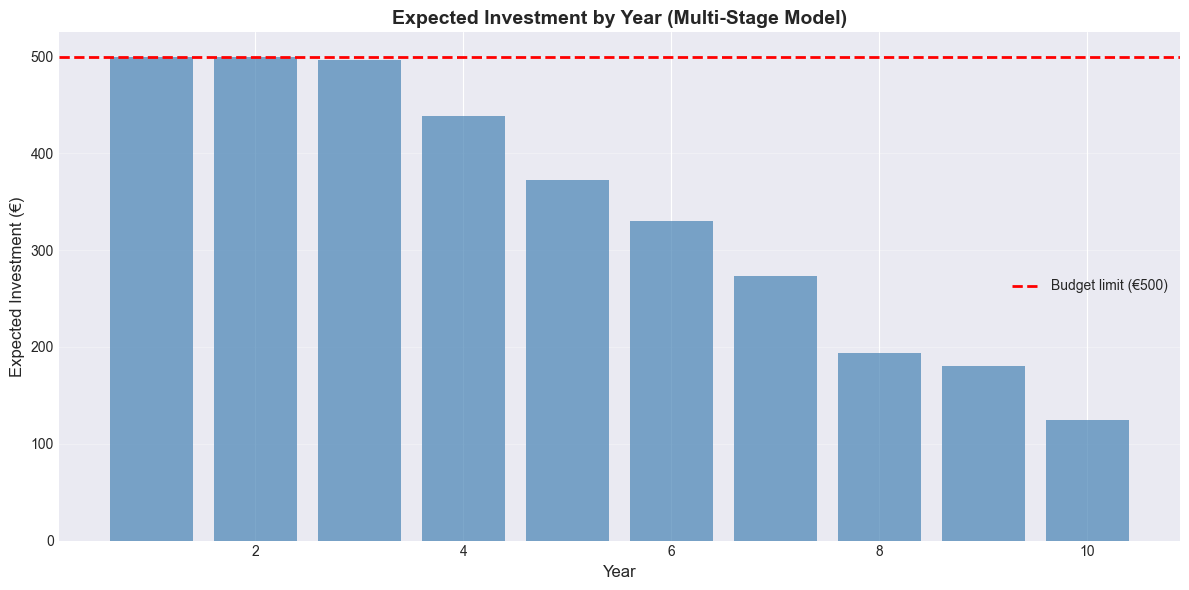

In [60]:
if model.status == GRB.OPTIMAL:
    # Expected investments per year
    fig, ax = plt.subplots(figsize=(12, 6))
    
    expected_investment = []
    for y in years:
        exp_inv = sum(
            path_prob[(y, path)] * sum(
                line_upgrade_vars[(bf, bt, y, path)].X * line_upgrade_cost
                for (bf, bt) in lines.keys()
            )
            for path in paths_by_year[y]
        )
        expected_investment.append(exp_inv)
    
    ax.bar(list(years), expected_investment, alpha=0.7, color='steelblue')
    ax.axhline(y=yearly_upgrade_budget, color='red', linestyle='--', 
               linewidth=2, label=f'Budget limit (€{yearly_upgrade_budget})')
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Expected Investment (€)', fontsize=12)
    ax.set_title('Expected Investment by Year (Multi-Stage Model)', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

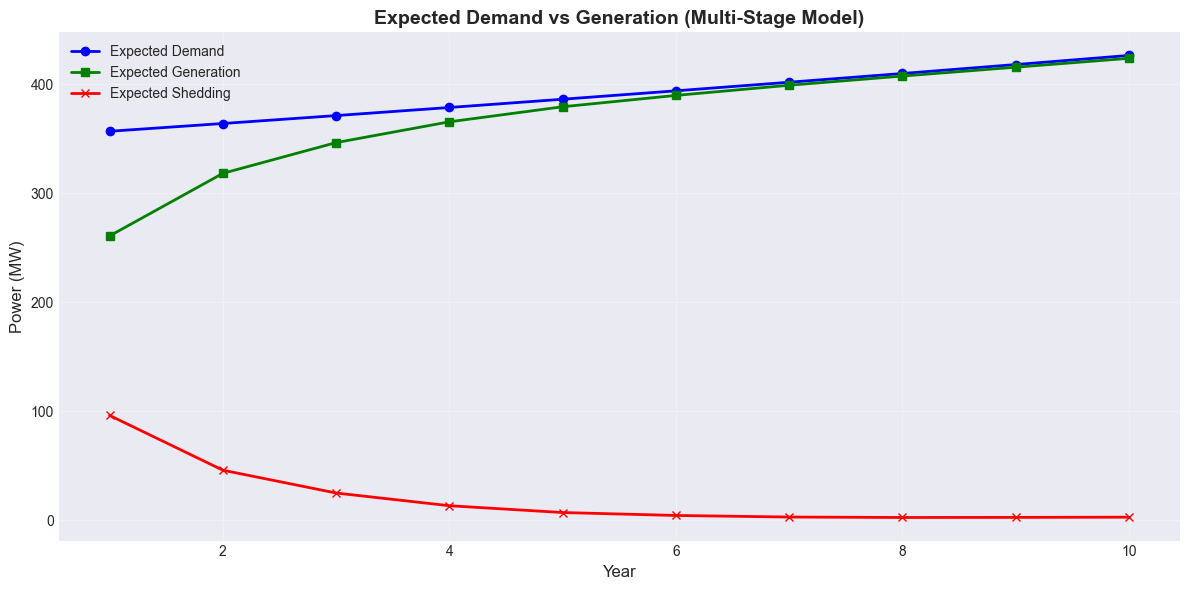

In [61]:
if model.status == GRB.OPTIMAL:
    # Expected demand vs generation
    fig, ax = plt.subplots(figsize=(12, 6))
    
    expected_demand_by_year = []
    expected_gen_by_year = []
    expected_shed_by_year = []
    
    for y in years:
        exp_demand = sum(
            path_prob[(y, path)] * sum(demand[(load, y, path)] for load in base_loads.keys())
            for path in paths_by_year[y]
        )
        exp_gen = sum(
            path_prob[(y, path)] * sum(gen_vars[(gen, y, path)].X for gen in generators.keys())
            for path in paths_by_year[y]
        )
        exp_shed = sum(
            path_prob[(y, path)] * sum(shed_vars[(load, y, path)].X for load in base_loads.keys())
            for path in paths_by_year[y]
        )
        expected_demand_by_year.append(exp_demand)
        expected_gen_by_year.append(exp_gen)
        expected_shed_by_year.append(exp_shed)
    
    ax.plot(list(years), expected_demand_by_year, marker='o', linewidth=2, 
            label='Expected Demand', color='blue')
    ax.plot(list(years), expected_gen_by_year, marker='s', linewidth=2, 
            label='Expected Generation', color='green')
    if max(expected_shed_by_year) > 0.01:
        ax.plot(list(years), expected_shed_by_year, marker='x', linewidth=2, 
                label='Expected Shedding', color='red')
    
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Power (MW)', fontsize=12)
    ax.set_title('Expected Demand vs Generation (Multi-Stage Model)', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## Key Insights

This multi-stage model captures:
1. **Sequential decision-making:** Investments made year-by-year based on observed history
2. **Path-dependent demand:** Demand in each year depends on all previous realizations
3. **Non-anticipativity:** Decisions cannot peek into the future
4. **Adaptive strategy:** Infrastructure plan adapts to realized demand patterns

The model is computationally intensive (exponential growth in scenarios) but provides the most realistic representation of actual planning under uncertainty.

---

## Results Summary and Analysis

In [62]:
if model.status == GRB.OPTIMAL:
    # Calculate detailed cost breakdown
    total_gen = sum(
        path_prob[(y, path)] * gen_vars[(gen, y, path)].X * generators[gen]['cost']
        for gen in generators.keys()
        for y in years
        for path in paths_by_year[y]
    )
    
    total_upgrade = sum(
        path_prob[(y, path)] * line_upgrade_vars[(bf, bt, y, path)].X * line_upgrade_cost
        for (bf, bt) in lines.keys()
        for y in years
        for path in paths_by_year[y]
    )
    
    total_shed = sum(
        path_prob[(y, path)] * shed_vars[(load, y, path)].X * VOLL
        for load in base_loads.keys()
        for y in years
        for path in paths_by_year[y]
    )
    
    print("=" * 70)
    print("COMPREHENSIVE RESULTS SUMMARY")
    print("=" * 70)
    
    print(f"\n1. COST BREAKDOWN:")
    print(f"   Expected Total Cost: €{model.objVal:.2f}")
    print(f"   - Generation Cost:   €{total_gen:.2f} ({total_gen/model.objVal*100:.1f}%)")
    print(f"   - Upgrade Cost:      €{total_upgrade:.2f} ({total_upgrade/model.objVal*100:.1f}%)")
    print(f"   - Shedding Cost:     €{total_shed:.2f} ({total_shed/model.objVal*100:.1f}%)")
    
    # Investment summary
    print(f"\n2. INVESTMENT SUMMARY:")
    total_capacity_added = 0
    lines_upgraded = set()
    for y in years:
        for path in paths_by_year[y]:
            for (bf, bt) in lines.keys():
                upgrade = line_upgrade_vars[(bf, bt, y, path)].X
                if upgrade > 0.1:
                    total_capacity_added += upgrade * path_prob[(y, path)]
                    lines_upgraded.add(f"{bf}-{bt}")
    
    print(f"   Expected total capacity added: {total_capacity_added:.2f} MW")
    print(f"   Number of lines with upgrades: {len(lines_upgraded)}")
    print(f"   Lines upgraded: {', '.join(sorted(lines_upgraded))}")
    print(f"   Average investment per year: €{total_upgrade/len(years):.2f}")
    
    # Operational summary
    print(f"\n3. OPERATIONAL PERFORMANCE:")
    expected_shed_mw = sum(
        path_prob[(y, path)] * shed_vars[(load, y, path)].X
        for load in base_loads.keys()
        for y in years
        for path in paths_by_year[y]
    )
    avg_annual_demand = sum(
        path_prob[(y, path)] * demand[(load, y, path)]
        for load in base_loads.keys()
        for y in years
        for path in paths_by_year[y]
    ) / len(years)
    
    print(f"   Expected total shedding: {expected_shed_mw:.2f} MW-years")
    print(f"   Average annual shedding: {expected_shed_mw/len(years):.2f} MW")
    print(f"   Average annual demand: {avg_annual_demand:.2f} MW")
    print(f"   Shedding as % of demand: {(expected_shed_mw/len(years))/avg_annual_demand*100:.2f}%")
    
    # Model characteristics
    print(f"\n4. MODEL CHARACTERISTICS:")
    print(f"   Planning horizon: {len(years)} years")
    print(f"   Total scenario paths: {len(paths_by_year[max(years)])}")
    print(f"   Variables: {model.NumVars:,}")
    print(f"   Constraints: {model.NumConstrs:,}")
    print(f"   Solution time: {model.Runtime:.2f} seconds")
    
    print("\n" + "=" * 70)

COMPREHENSIVE RESULTS SUMMARY

1. COST BREAKDOWN:
   Expected Total Cost: €88413.15
   - Generation Cost:   €64895.86 (73.4%)
   - Upgrade Cost:      €3408.64 (3.9%)
   - Shedding Cost:     €20108.65 (22.7%)

2. INVESTMENT SUMMARY:
   Expected total capacity added: 681.73 MW
   Number of lines with upgrades: 9
   Lines upgraded: Bus1-Bus2, Bus1-Bus4, Bus2-Bus3, Bus2-Bus5, Bus3-Bus6, Bus4-Bus7, Bus5-Bus7, Bus6-Bus8, Bus7-Bus8
   Average investment per year: €340.86

3. OPERATIONAL PERFORMANCE:
   Expected total shedding: 201.09 MW-years
   Average annual shedding: 20.11 MW
   Average annual demand: 390.91 MW
   Shedding as % of demand: 5.14%

4. MODEL CHARACTERISTICS:
   Planning horizon: 10 years
   Total scenario paths: 1024
   Variables: 73,656
   Constraints: 92,060
   Solution time: 2.11 seconds



### Visualization 1: Cost Breakdown Pie Chart

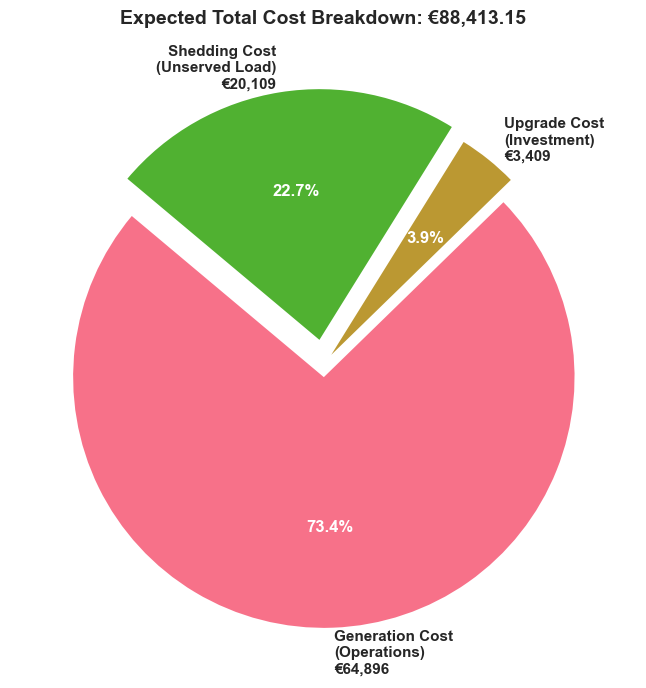

In [63]:
if model.status == GRB.OPTIMAL:
    sns.set_palette("husl")
    fig, ax = plt.subplots(figsize=(10, 7))
    
    costs = [total_gen, total_upgrade, total_shed]
    labels = ['Generation Cost\n(Operations)', 'Upgrade Cost\n(Investment)', 'Shedding Cost\n(Unserved Load)']
    
    explode = (0.05, 0.05, 0.1)
    
    wedges, texts, autotexts = ax.pie(
        costs, labels=labels, autopct='%1.1f%%', explode=explode, startangle=140,
        textprops={'fontsize': 11, 'weight': 'bold'}
    )
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(12)
    
    # Add value annotations
    for i, (cost, label) in enumerate(zip(costs, labels)):
        texts[i].set_text(f'{label}\n€{cost:,.0f}')
    
    ax.set_title(f'Expected Total Cost Breakdown: €{model.objVal:,.2f}', 
                 fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()

### Visualization 2: Cumulative Line Upgrades by Line

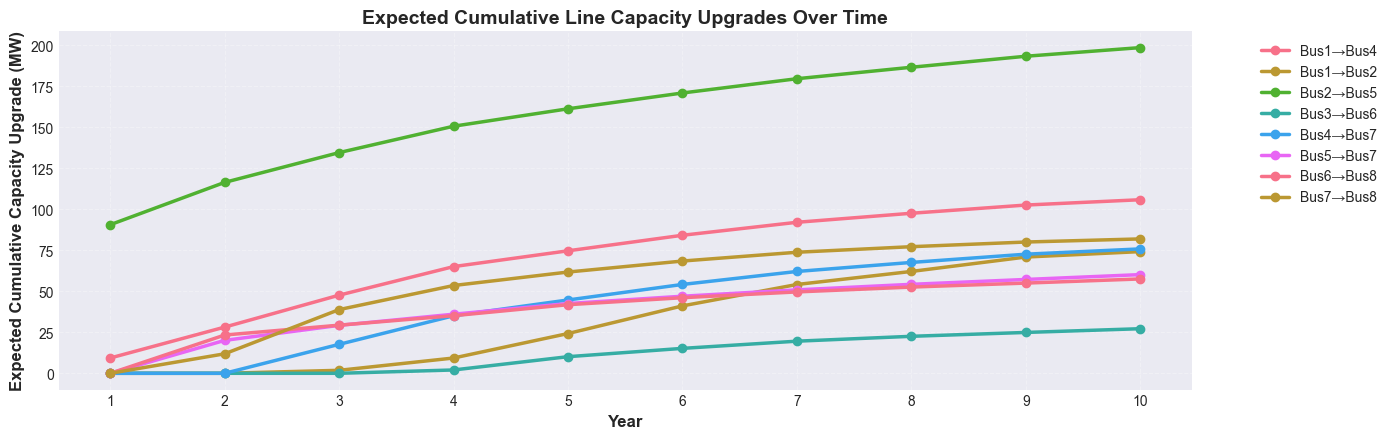

In [75]:
if model.status == GRB.OPTIMAL:
    # Calculate expected cumulative upgrades by line
    line_cumulative = {}
    for (bf, bt) in lines.keys():
        line_cumulative[(bf, bt)] = []
        for y in years:
            cum_upgrade = sum(
                path_prob[(yy, path)] * line_upgrade_vars[(bf, bt, yy, path)].X
                for yy in range(1, y + 1)
                for path in paths_by_year[yy]
            )
            line_cumulative[(bf, bt)].append(cum_upgrade)
    
    # Filter lines with significant upgrades
    significant_lines = [(bf, bt) for (bf, bt) in lines.keys() 
                         if max(line_cumulative[(bf, bt)]) > 0.5]
    
    fig, ax = plt.subplots(figsize=(14, 4.5))
    
    for (bf, bt) in significant_lines:
        ax.plot(list(years), line_cumulative[(bf, bt)], 
               marker='o', linewidth=2.5, markersize=6,
               label=f'{bf}→{bt}')
    
    ax.set_xlabel('Year', fontsize=12, fontweight='bold')
    ax.set_ylabel('Expected Cumulative Capacity Upgrade (MW)', fontsize=12, fontweight='bold')
    ax.set_title('Expected Cumulative Line Capacity Upgrades Over Time', 
                 fontsize=14, fontweight='bold')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xticks(list(years))
    
    plt.tight_layout()
    plt.show()

### Visualization 3: Demand Scenario Fan Chart

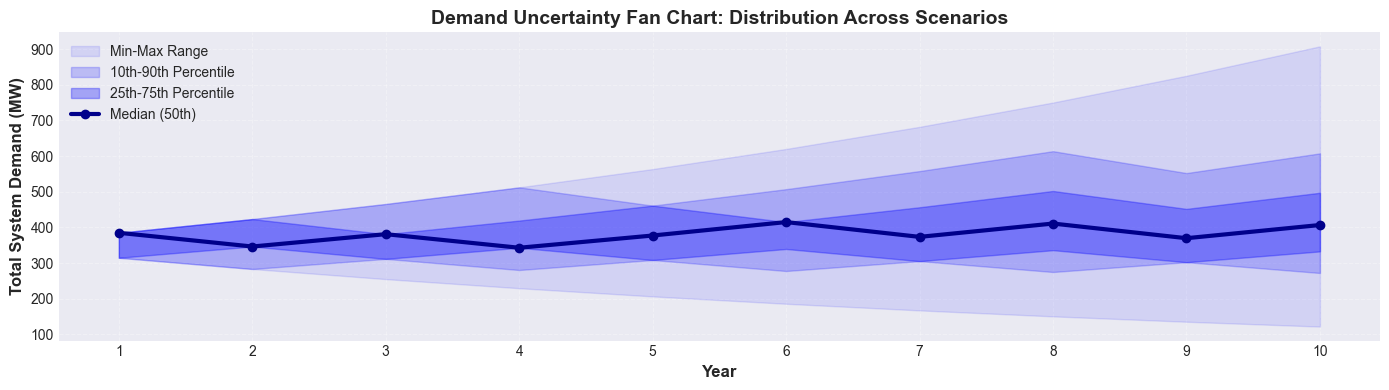

In [65]:
if model.status == GRB.OPTIMAL:
    # Calculate demand ranges across scenarios
    demand_percentiles = {p: [] for p in [10, 25, 50, 75, 90]}
    demand_min = []
    demand_max = []
    
    for y in years:
        total_demands = []
        for path in paths_by_year[y]:
            total_dem = sum(demand[(load, y, path)] for load in base_loads.keys())
            prob = path_prob[(y, path)]
            total_demands.append((total_dem, prob))
        
        # Sort by demand
        total_demands.sort(key=lambda x: x[0])
        
        # Calculate weighted percentiles
        cumulative_prob = 0
        demand_min.append(total_demands[0][0])
        demand_max.append(total_demands[-1][0])
        
        for percentile in [10, 25, 50, 75, 90]:
            target = percentile / 100
            cumulative_prob = 0
            for dem, prob in total_demands:
                cumulative_prob += prob
                if cumulative_prob >= target:
                    demand_percentiles[percentile].append(dem)
                    break
    
    fig, ax = plt.subplots(figsize=(14, 4))
    
    # Plot fan chart
    ax.fill_between(list(years), demand_min, demand_max, 
                     alpha=0.1, color='blue', label='Min-Max Range')
    ax.fill_between(list(years), demand_percentiles[10], demand_percentiles[90], 
                     alpha=0.2, color='blue', label='10th-90th Percentile')
    ax.fill_between(list(years), demand_percentiles[25], demand_percentiles[75], 
                     alpha=0.3, color='blue', label='25th-75th Percentile')
    ax.plot(list(years), demand_percentiles[50], 
           color='darkblue', linewidth=3, marker='o', markersize=6, label='Median (50th)')
    
    ax.set_xlabel('Year', fontsize=12, fontweight='bold')
    ax.set_ylabel('Total System Demand (MW)', fontsize=12, fontweight='bold')
    ax.set_title('Demand Uncertainty Fan Chart: Distribution Across Scenarios', 
                 fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xticks(list(years))
    
    plt.tight_layout()
    plt.show()

### Visualization 4: Generation Mix Stacked Area Chart

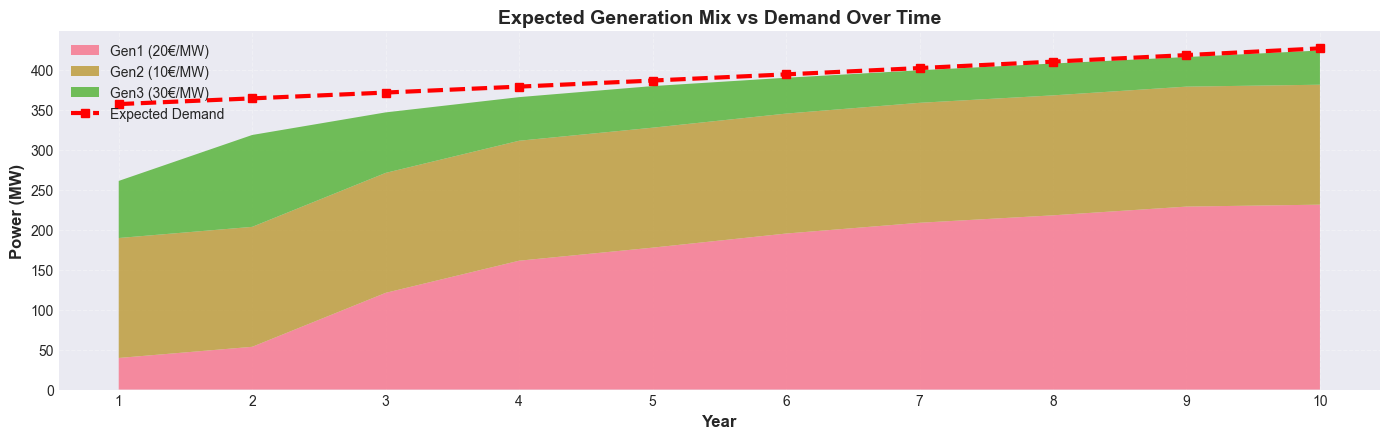

In [73]:
if model.status == GRB.OPTIMAL:
    # Calculate expected generation by generator
    active_gens = [gen for gen in generators.keys() if generators[gen]['capacity'] > 0]
    gen_by_year = {gen: [] for gen in active_gens}
    
    for y in years:
        for gen in active_gens:
            exp_gen = sum(
                path_prob[(y, path)] * gen_vars[(gen, y, path)].X
                for path in paths_by_year[y]
            )
            gen_by_year[gen].append(exp_gen)
    
    fig, ax = plt.subplots(figsize=(14, 4.5))
    
    # Create stacked area chart
    ax.stackplot(list(years), 
                [gen_by_year[gen] for gen in active_gens],
                labels=[f'{gen} ({generators[gen]["cost"]}€/MW)' for gen in active_gens],
                alpha=0.8)
    
    # Add expected demand line
    ax.plot(list(years), expected_demand_by_year, 
           color='red', linewidth=3, linestyle='--', 
           marker='s', markersize=6, label='Expected Demand')
    
    ax.set_xlabel('Year', fontsize=12, fontweight='bold')
    ax.set_ylabel('Power (MW)', fontsize=12, fontweight='bold')
    ax.set_title('Expected Generation Mix vs Demand Over Time', 
                 fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xticks(list(years))
    
    plt.tight_layout()
    plt.show()

### Visualization 5: Load Shedding Analysis

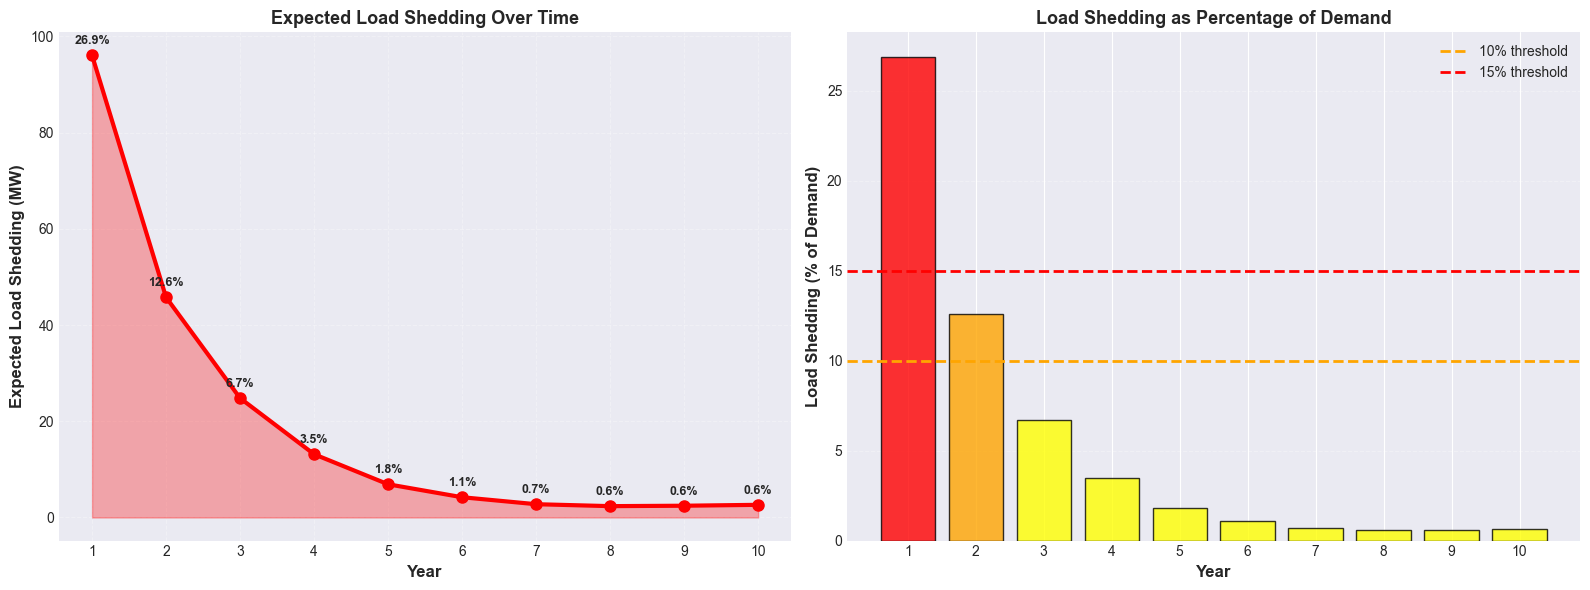

In [67]:
if model.status == GRB.OPTIMAL:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Left plot: Shedding over time
    ax1.plot(list(years), expected_shed_by_year, 
            color='red', linewidth=3, marker='o', markersize=8)
    ax1.fill_between(list(years), expected_shed_by_year, 
                     alpha=0.3, color='red')
    
    # Add percentage annotation
    for i, (y, shed) in enumerate(zip(years, expected_shed_by_year)):
        pct = (shed / expected_demand_by_year[i]) * 100
        if shed > 1:
            ax1.annotate(f'{pct:.1f}%', 
                        xy=(y, shed), xytext=(0, 8),
                        textcoords='offset points', ha='center',
                        fontsize=9, fontweight='bold')
    
    ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Expected Load Shedding (MW)', fontsize=12, fontweight='bold')
    ax1.set_title('Expected Load Shedding Over Time', fontsize=13, fontweight='bold')
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_xticks(list(years))
    
    # Right plot: Shedding as percentage of demand
    shedding_pct = [(shed / dem) * 100 
                    for shed, dem in zip(expected_shed_by_year, expected_demand_by_year)]
    
    colors_bar = ['red' if pct > 15 else 'orange' if pct > 10 else 'yellow' 
                  for pct in shedding_pct]
    bars = ax2.bar(list(years), shedding_pct, color=colors_bar, alpha=0.8, edgecolor='black')
    
    # Add threshold line
    ax2.axhline(y=10, color='orange', linestyle='--', linewidth=2, label='10% threshold')
    ax2.axhline(y=15, color='red', linestyle='--', linewidth=2, label='15% threshold')
    
    ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Load Shedding (% of Demand)', fontsize=12, fontweight='bold')
    ax2.set_title('Load Shedding as Percentage of Demand', fontsize=13, fontweight='bold')
    ax2.legend(loc='upper right', fontsize=10)
    ax2.grid(True, alpha=0.3, linestyle='--', axis='y')
    ax2.set_xticks(list(years))
    
    plt.tight_layout()
    plt.show()

### Visualization 6: Network Upgrade Investment Pattern

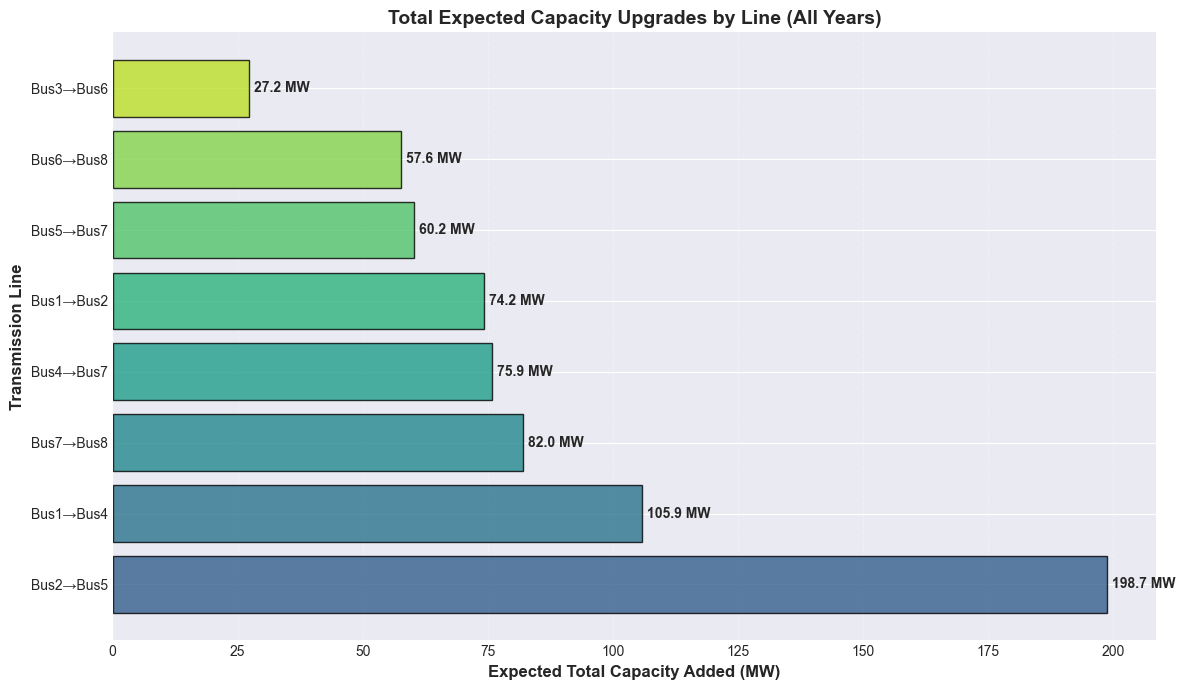

In [68]:
if model.status == GRB.OPTIMAL:
    # Calculate total expected upgrade by line across all years
    total_by_line = {}
    for (bf, bt) in lines.keys():
        total = sum(
            path_prob[(y, path)] * line_upgrade_vars[(bf, bt, y, path)].X
            for y in years
            for path in paths_by_year[y]
        )
        if total > 0.5:
            total_by_line[f'{bf}→{bt}'] = total
    
    # Sort by total upgrade
    sorted_lines = sorted(total_by_line.items(), key=lambda x: x[1], reverse=True)
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    line_names = [item[0] for item in sorted_lines]
    line_values = [item[1] for item in sorted_lines]
    
    colors_gradient = plt.cm.viridis(np.linspace(0.3, 0.9, len(line_names)))
    bars = ax.barh(line_names, line_values, color=colors_gradient, alpha=0.8, edgecolor='black')
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, line_values)):
        ax.text(val + 1, i, f'{val:.1f} MW', 
               va='center', fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Expected Total Capacity Added (MW)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Transmission Line', fontsize=12, fontweight='bold')
    ax.set_title('Total Expected Capacity Upgrades by Line (All Years)', 
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--', axis='x')
    
    plt.tight_layout()
    plt.show()

### Visualization 7: Comprehensive Dashboard

/var/folders/wp/qqfmm2_s4w56mpj5wxp6ws9r0000gn/T/ipykernel_6246/3842634266.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


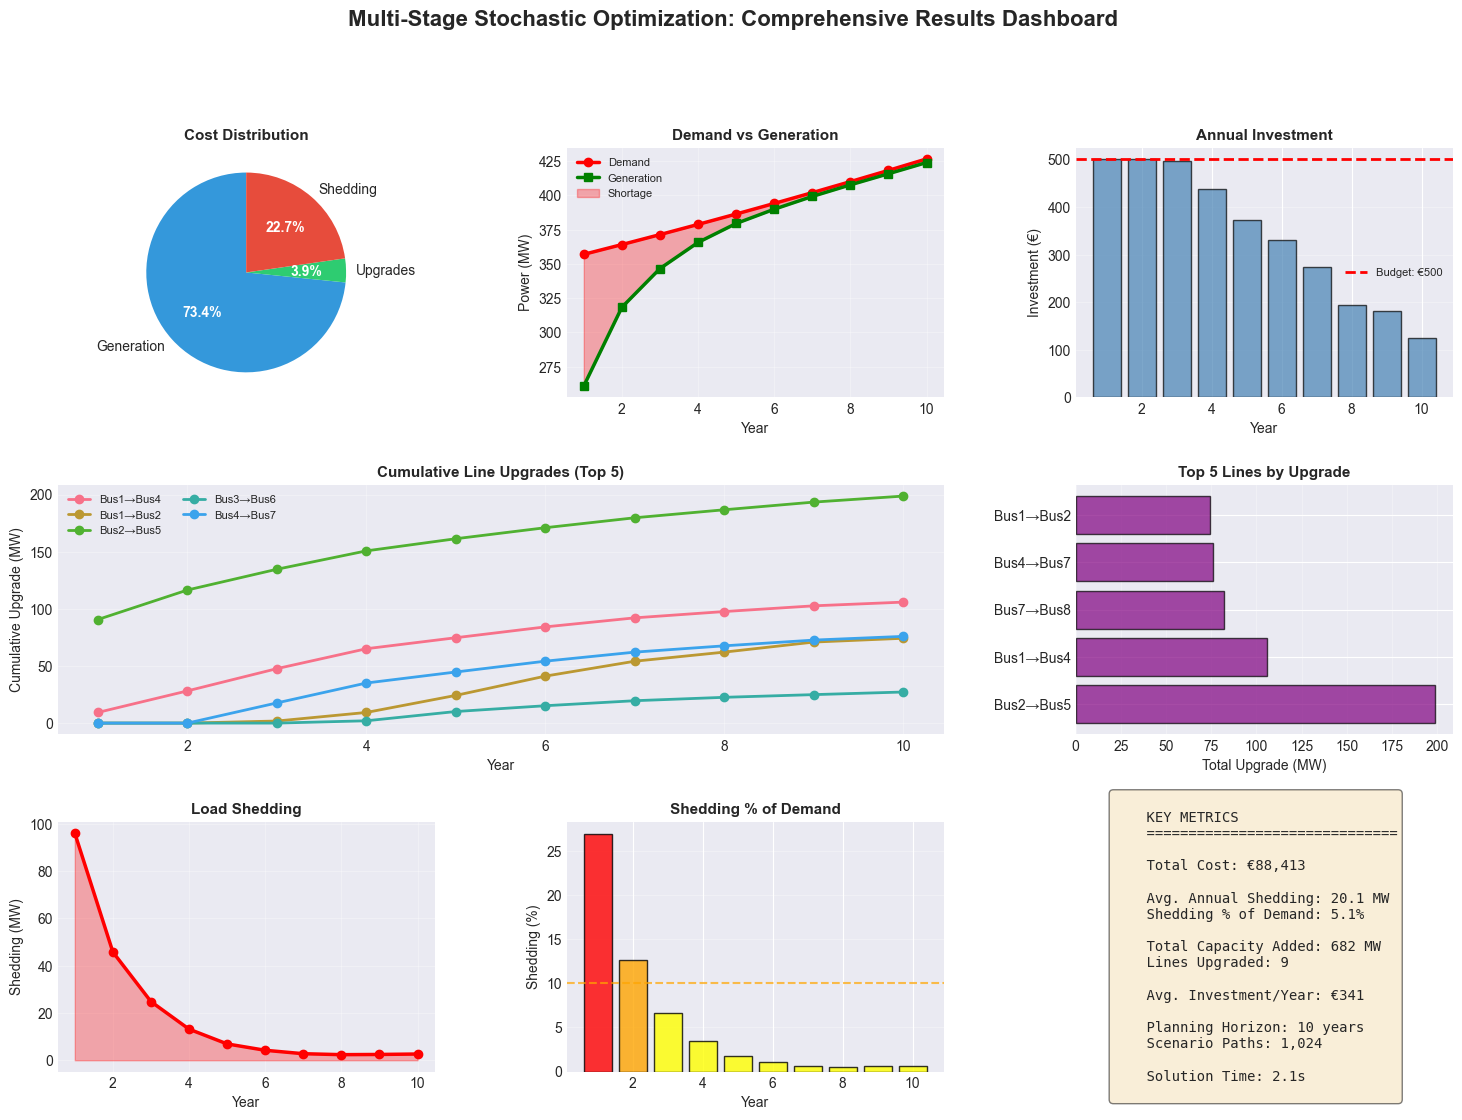

In [69]:
if model.status == GRB.OPTIMAL:
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.35)
    
    # 1. Cost breakdown (top left)
    ax1 = fig.add_subplot(gs[0, 0])
    costs = [total_gen, total_upgrade, total_shed]
    labels = ['Generation', 'Upgrades', 'Shedding']
    colors_pie = ['#3498db', '#2ecc71', '#e74c3c']
    wedges, texts, autotexts = ax1.pie(costs, labels=labels, autopct='%1.1f%%', 
                                        colors=colors_pie, startangle=90)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    ax1.set_title('Cost Distribution', fontweight='bold', fontsize=11)
    
    # 2. Expected demand vs generation (top middle)
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(list(years), expected_demand_by_year, marker='o', linewidth=2.5, 
            color='red', label='Demand')
    ax2.plot(list(years), expected_gen_by_year, marker='s', linewidth=2.5, 
            color='green', label='Generation')
    ax2.fill_between(list(years), expected_gen_by_year, expected_demand_by_year,
                     where=(np.array(expected_demand_by_year) > np.array(expected_gen_by_year)),
                     alpha=0.3, color='red', label='Shortage')
    ax2.set_xlabel('Year', fontsize=10)
    ax2.set_ylabel('Power (MW)', fontsize=10)
    ax2.set_title('Demand vs Generation', fontweight='bold', fontsize=11)
    ax2.legend(fontsize=8)
    ax2.grid(True, alpha=0.3)
    
    # 3. Investment over time (top right)
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.bar(list(years), expected_investment, color='steelblue', alpha=0.7, edgecolor='black')
    ax3.axhline(y=yearly_upgrade_budget, color='red', linestyle='--', linewidth=2, 
               label=f'Budget: €{yearly_upgrade_budget}')
    ax3.set_xlabel('Year', fontsize=10)
    ax3.set_ylabel('Investment (€)', fontsize=10)
    ax3.set_title('Annual Investment', fontweight='bold', fontsize=11)
    ax3.legend(fontsize=8)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. Cumulative upgrades (middle left, spans 2 columns)
    ax4 = fig.add_subplot(gs[1, :2])
    for (bf, bt) in significant_lines[:5]:  # Top 5 lines
        ax4.plot(list(years), line_cumulative[(bf, bt)], 
                marker='o', linewidth=2, label=f'{bf}→{bt}')
    ax4.set_xlabel('Year', fontsize=10)
    ax4.set_ylabel('Cumulative Upgrade (MW)', fontsize=10)
    ax4.set_title('Cumulative Line Upgrades (Top 5)', fontweight='bold', fontsize=11)
    ax4.legend(fontsize=8, ncol=2)
    ax4.grid(True, alpha=0.3)
    
    # 5. Total upgrades by line (middle right)
    ax5 = fig.add_subplot(gs[1, 2])
    top_5_lines = sorted_lines[:5]
    line_names_short = [item[0] for item in top_5_lines]
    line_vals = [item[1] for item in top_5_lines]
    ax5.barh(line_names_short, line_vals, color='purple', alpha=0.7, edgecolor='black')
    ax5.set_xlabel('Total Upgrade (MW)', fontsize=10)
    ax5.set_title('Top 5 Lines by Upgrade', fontweight='bold', fontsize=11)
    ax5.grid(True, alpha=0.3, axis='x')
    
    # 6. Shedding over time (bottom left)
    ax6 = fig.add_subplot(gs[2, 0])
    ax6.plot(list(years), expected_shed_by_year, marker='o', linewidth=2.5, 
            color='red')
    ax6.fill_between(list(years), expected_shed_by_year, alpha=0.3, color='red')
    ax6.set_xlabel('Year', fontsize=10)
    ax6.set_ylabel('Shedding (MW)', fontsize=10)
    ax6.set_title('Load Shedding', fontweight='bold', fontsize=11)
    ax6.grid(True, alpha=0.3)
    
    # 7. Shedding percentage (bottom middle)
    ax7 = fig.add_subplot(gs[2, 1])
    shedding_pct = [(shed / dem) * 100 
                    for shed, dem in zip(expected_shed_by_year, expected_demand_by_year)]
    colors_bar = ['red' if pct > 15 else 'orange' if pct > 10 else 'yellow' 
                  for pct in shedding_pct]
    ax7.bar(list(years), shedding_pct, color=colors_bar, alpha=0.8, edgecolor='black')
    ax7.axhline(y=10, color='orange', linestyle='--', linewidth=1.5, alpha=0.7)
    ax7.set_xlabel('Year', fontsize=10)
    ax7.set_ylabel('Shedding (%)', fontsize=10)
    ax7.set_title('Shedding % of Demand', fontweight='bold', fontsize=11)
    ax7.grid(True, alpha=0.3, axis='y')
    
    # 8. Key metrics text box (bottom right)
    ax8 = fig.add_subplot(gs[2, 2])
    ax8.axis('off')
    
    metrics_text = f"""
    KEY METRICS
    {'='*30}
    
    Total Cost: €{model.objVal:,.0f}
    
    Avg. Annual Shedding: {expected_shed_mw/len(years):.1f} MW
    Shedding % of Demand: {(expected_shed_mw/len(years))/avg_annual_demand*100:.1f}%
    
    Total Capacity Added: {total_capacity_added:.0f} MW
    Lines Upgraded: {len(lines_upgraded)}
    
    Avg. Investment/Year: €{total_upgrade/len(years):.0f}
    
    Planning Horizon: {len(years)} years
    Scenario Paths: {len(paths_by_year[max(years)]):,}
    
    Solution Time: {model.Runtime:.1f}s
    """
    
    ax8.text(0.1, 0.5, metrics_text, fontsize=10, verticalalignment='center',
            family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    fig.suptitle('Multi-Stage Stochastic Optimization: Comprehensive Results Dashboard', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    plt.tight_layout()
    plt.show()

# Sensitivity analysis 

## Scenario probabilities

In [70]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd


def solve_stochastic_for_p_high(p_high):
    """
    Solve Model 3 stochastic planning with DC power flow (angles included).
    """

    # Update scenario probabilities
    scenario_probabilities['high'] = p_high
    scenario_probabilities['low']  = 1.0 - p_high

    # Rebuild scenario tree
    paths_by_year, path_prob, demand = build_scenario_tree(PLANNING_YEARS)

    # ---------------- Build model ----------------
    model = gp.Model(f"Multistage_Stochastic_p_high_{p_high:.2f}")
    model.Params.OutputFlag = 0

    # ========================================
    # VOLTAGE ANGLES (NEW)
    # ========================================
    theta = {}
    for y in years:
        for path in paths_by_year[y]:
            for bus in buses.keys():
                theta[(bus, y, path)] = model.addVar(
                    lb=-GRB.INFINITY,
                    name=f"Theta_{bus}_Y{y}_P{path}"
                )

    # Slack bus = 0
    slack_bus = "Bus1"
    for y in years:
        for path in paths_by_year[y]:
            model.addConstr(
                theta[(slack_bus, y, path)] == 0,
                name=f"Slack_{slack_bus}_Y{y}_P{path}"
            )

    # ========================================
    # INVESTMENT VARIABLES
    # ========================================
    line_upgrade_vars = {}
    for y in years:
        for path in paths_by_year[y]:
            for (bus_from, bus_to) in lines.keys():
                line_upgrade_vars[(bus_from, bus_to, y, path)] = model.addVar(
                    lb=0,
                    name=f"Upgrade_{bus_from}_{bus_to}_Y{y}_P{path}"
                )

    # ========================================
    # OPERATIONAL VARIABLES
    # ========================================
    gen_vars = {}
    line_vars = {}
    shed_vars = {}

    for y in years:
        for path in paths_by_year[y]:
            for gen, gen_data in generators.items():
                gen_vars[(gen, y, path)] = model.addVar(
                    lb=0, ub=gen_data['capacity'],
                    name=f"Gen_{gen}_Y{y}_P{path}"
                )
            for (bus_from, bus_to) in lines.keys():
                line_vars[(bus_from, bus_to, y, path)] = model.addVar(
                    lb=-GRB.INFINITY,
                    name=f"Flow_{bus_from}_{bus_to}_Y{y}_P{path}"
                )
            for load in base_loads.keys():
                shed_vars[(load, y, path)] = model.addVar(
                    lb=0,
                    name=f"Shed_{load}_Y{y}_P{path}"
                )

    model.update()

    # ========================================
    # DC POWER FLOW CONSTRAINTS (NEW)
    # ========================================
    for (bus_from, bus_to), data in lines.items():
        x = data['reactance']
        b = 1.0 / x
        for y in years:
            for path in paths_by_year[y]:
                f = line_vars[(bus_from, bus_to, y, path)]
                model.addConstr(
                    f == b * (theta[(bus_from, y, path)] - theta[(bus_to, y, path)]),
                    name=f"DCFlow_{bus_from}_{bus_to}_Y{y}_P{path}"
                )

    # ========================================
    # NON-ANTICIPATIVITY
    # ========================================
    for y in range(2, PLANNING_YEARS + 1):
        history_groups = {}
        for path in paths_by_year[y]:
            hist = path[:-1]
            history_groups.setdefault(hist, []).append(path)

        for hist, paths in history_groups.items():
            ref_path = paths[0]
            for p in paths[1:]:
                for (bf, bt) in lines.keys():
                    model.addConstr(
                        line_upgrade_vars[(bf, bt, y, p)]
                        == line_upgrade_vars[(bf, bt, y, ref_path)]
                    )

    # ========================================
    # LINE CAPACITY CONSTRAINTS
    # ========================================
    for y in years:
        for path in paths_by_year[y]:
            for (bf, bt), data in lines.items():
                f = line_vars[(bf, bt, y, path)]
                base_cap = data['capacity']

                cum_up = gp.LinExpr()
                for yy in range(1, y + 1):
                    p_yy = path[:yy]
                    cum_up += line_upgrade_vars[(bf, bt, yy, p_yy)]

                cap = base_cap + cum_up
                model.addConstr(f <=  cap)
                model.addConstr(f >= -cap)

    # ========================================
    # BUDGET CONSTRAINTS
    # ========================================
    for y in years:
        for path in paths_by_year[y]:
            model.addConstr(
                gp.quicksum(
                    line_upgrade_cost * line_upgrade_vars[(bf, bt, y, path)]
                    for (bf, bt) in lines.keys()
                ) <= yearly_upgrade_budget
            )

    # ========================================
    # POWER BALANCE
    # ========================================
    for y in years:
        for path in paths_by_year[y]:
            for bus in buses.keys():

                gen = gp.quicksum(
                    gen_vars[(g, y, path)]
                    for g,gdata in generators.items()
                    if gdata['bus'] == bus
                )

                inflow = gp.quicksum(
                    line_vars[(bf, bt, y, path)]
                    for (bf, bt) in lines.keys() if bt == bus
                )
                outflow = gp.quicksum(
                    line_vars[(bf, bt, y, path)]
                    for (bf, bt) in lines.keys() if bf == bus
                )

                shed = gp.quicksum(
                    shed_vars[(load, y, path)]
                    for load,ldata in base_loads.items()
                    if ldata['bus'] == bus
                )

                demand_bus = sum(
                    demand[(load, y, path)]
                    for load,ldata in base_loads.items()
                    if ldata['bus'] == bus
                )

                model.addConstr(gen + inflow - outflow + shed == demand_bus)

    # ========================================
    # OBJECTIVE: EXPECTED COST
    # ========================================
    total_cost_expr = gp.LinExpr()
    for y in years:
        for path in paths_by_year[y]:
            prob = path_prob[(y, path)]
            for g in generators.keys():
                total_cost_expr += prob * gen_vars[(g, y, path)] * generators[g]['cost']
            for (bf, bt) in lines.keys():
                total_cost_expr += prob * line_upgrade_vars[(bf, bt, y, path)] * line_upgrade_cost
            for load in base_loads.keys():
                total_cost_expr += prob * shed_vars[(load, y, path)] * VOLL

    model.setObjective(total_cost_expr, GRB.MINIMIZE)
    model.optimize()

    if model.status != GRB.OPTIMAL:
        raise RuntimeError(f"Not optimal for p_high={p_high}")

    # ========================================
    # Expected load shedding
    # ========================================
    expected_shed = 0.0
    for y in years:
        for path in paths_by_year[y]:
            prob = path_prob[(y, path)]
            expected_shed += prob * sum(
                shed_vars[(load, y, path)].X
                for load in base_loads.keys()
            )

    # ========================================
    # Expected line upgrades
    # ========================================
    expected_upgrades = {(bf,bt): 0.0 for (bf,bt) in lines.keys()}
    for y in years:
        for path in paths_by_year[y]:
            prob = path_prob[(y, path)]
            for (bf, bt) in lines.keys():
                expected_upgrades[(bf, bt)] += prob * line_upgrade_vars[(bf, bt, y, path)].X

    return model.objVal, expected_shed, expected_upgrades



p_high_values = [0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
results = []

for p in p_high_values:
    cost, shed, exp_up = solve_stochastic_for_p_high(p)
    results.append({"p_high": p, "cost": cost, "expected_shed": shed, "exp_upgrades": exp_up})
    print(f"p_high={p:.2f}: cost = €{cost:,.2f}, expected shedding = {shed:.2f} MW")


rows = []
for res in results:
    p = res["p_high"]
    for (bf, bt), val in res["exp_upgrades"].items():
        rows.append({
            "p_high": p,
            "line": f"{bf}-{bt}",
            "expected_upgrade": val
        })

df_exp_upgrades = pd.DataFrame(rows)
print("\nExpected upgrades per line and p_high:")
print(df_exp_upgrades)


p_high=0.20: cost = €45,816.03, expected shedding = 91.98 MW
p_high=0.30: cost = €53,785.26, expected shedding = 110.67 MW
p_high=0.40: cost = €63,131.23, expected shedding = 132.98 MW
p_high=0.50: cost = €74,396.75, expected shedding = 161.73 MW
p_high=0.60: cost = €88,413.15, expected shedding = 201.09 MW
p_high=0.70: cost = €106,561.62, expected shedding = 271.20 MW
p_high=0.80: cost = €130,667.67, expected shedding = 392.02 MW

Expected upgrades per line and p_high:
    p_high       line  expected_upgrade
0      0.2  Bus1-Bus4         51.091816
1      0.2  Bus1-Bus2          5.097651
2      0.2  Bus2-Bus3          0.000000
3      0.2  Bus2-Bus5        130.611277
4      0.2  Bus3-Bus6          0.068755
..     ...        ...               ...
65     0.8  Bus4-Bus7        101.415480
66     0.8  Bus5-Bus7         91.628106
67     0.8  Bus5-Bus6          0.000000
68     0.8  Bus6-Bus8         89.850064
69     0.8  Bus7-Bus8         85.785822

[70 rows x 3 columns]


## Visualisation

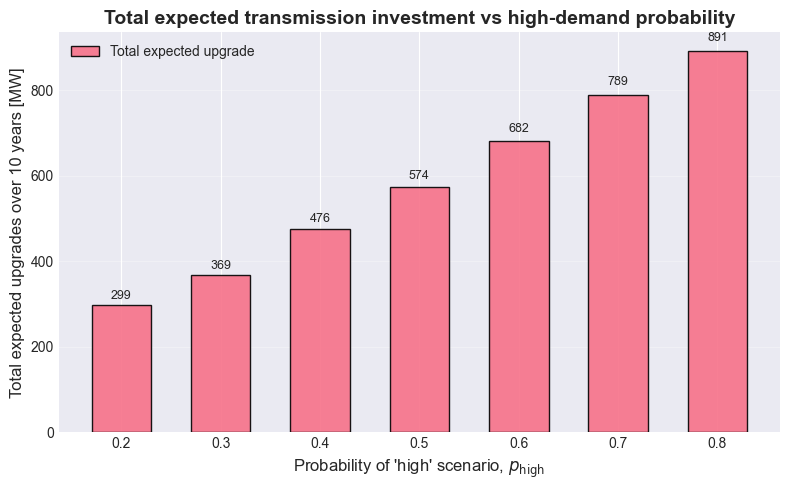

Dashed (<0.5 MW): ['Bus5-Bus6']
Solid (>=0.5 MW): ['Bus1-Bus4', 'Bus1-Bus2', 'Bus2-Bus3', 'Bus2-Bus5', 'Bus3-Bus6', 'Bus4-Bus7', 'Bus5-Bus7', 'Bus6-Bus8', 'Bus7-Bus8']


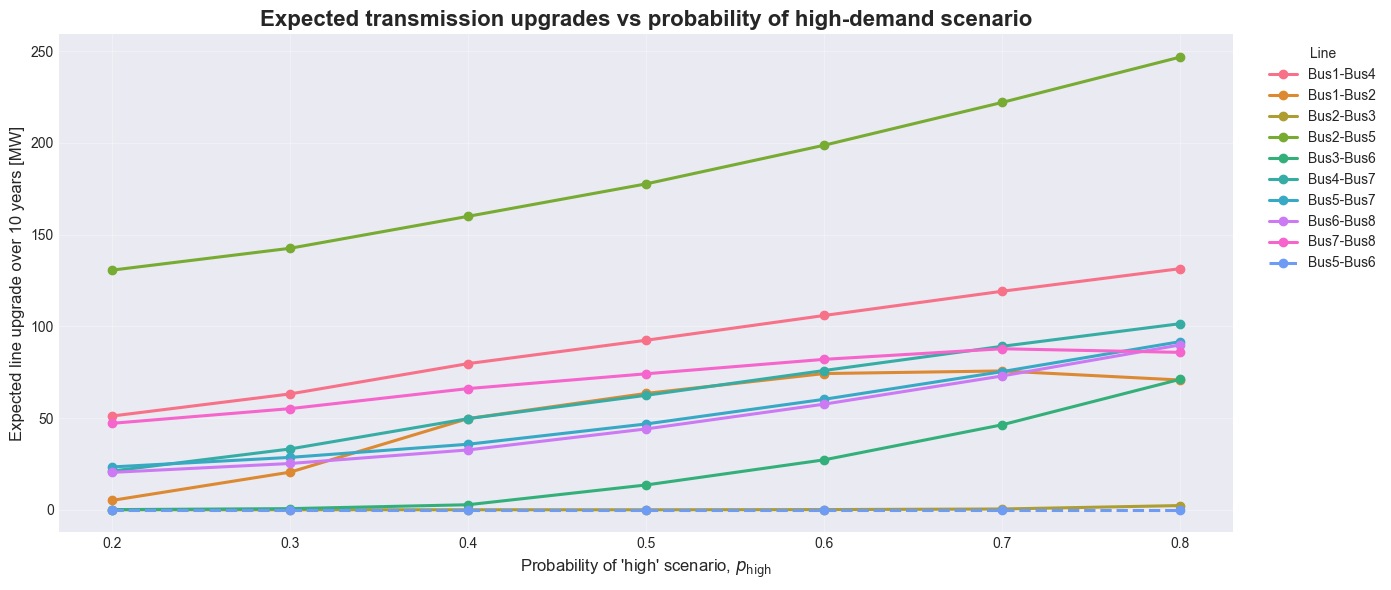

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def thousands(x, pos):
    return f"{x:,.0f}"

df_plot = df_exp_upgrades.copy()


df_total_up = (
    df_plot.groupby("p_high", as_index=False)["expected_upgrade"]
    .sum()
    .rename(columns={"expected_upgrade": "total_expected_upgrade"})
)

fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(
    df_total_up["p_high"],
    df_total_up["total_expected_upgrade"],
    width=0.06,
    edgecolor="black",
    alpha=0.9,
    label="Total expected upgrade"
)

# Annotate bars
for x, val in zip(df_total_up["p_high"], df_total_up["total_expected_upgrade"]):
    ax.text(x, val * 1.02, f"{val:.0f}", ha="center", va="bottom", fontsize=9)

ax.set_xlabel("Probability of 'high' scenario, $p_{\\mathrm{high}}$", fontsize=12)
ax.set_ylabel("Total expected upgrades over 10 years [MW]", fontsize=12)
ax.set_title("Total expected transmission investment vs high-demand probability",
             fontsize=14, fontweight="bold")

ax.yaxis.set_major_formatter(FuncFormatter(thousands))
ax.grid(axis="y", alpha=0.3)
ax.legend(loc="upper left")

plt.tight_layout()
plt.show()
# plt.savefig("Figures/Model 3/total_expected_upgrades.png", dpi=300, bbox_inches="tight")

threshold = 0.5
max_by_line = df_plot.groupby("line")["expected_upgrade"].max()

tiny_lines = list(max_by_line[max_by_line < threshold].index)
normal_lines = [l for l in df_plot["line"].unique() if l not in tiny_lines]

print("Dashed (<0.5 MW):", tiny_lines)
print("Solid (>=0.5 MW):", normal_lines)

# Create colour map for all lines
palette = sns.husl_palette(len(df_plot["line"].unique()))
color_map = dict(zip(df_plot["line"].unique(), palette))

fig, ax = plt.subplots(figsize=(14, 6))

# Solid lines
for line in normal_lines:
    df_line = df_plot[df_plot["line"] == line]
    ax.plot(
        df_line["p_high"],
        df_line["expected_upgrade"],
        marker="o",
        linewidth=2.2,
        linestyle="-",
        color=color_map[line],
        label=line
    )

# Dashed lines (same colour)
for line in tiny_lines:
    df_line = df_plot[df_plot["line"] == line]
    ax.plot(
        df_line["p_high"],
        df_line["expected_upgrade"],
        marker="o",
        linewidth=2.2,
        linestyle="--",
        color=color_map[line],
        label=f"{line}"
    )

ax.set_xlabel("Probability of 'high' scenario, $p_{\\mathrm{high}}$", fontsize=12)
ax.set_ylabel("Expected line upgrade over 10 years [MW]", fontsize=12)
ax.set_title("Expected transmission upgrades vs probability of high-demand scenario",
             fontsize=16, fontweight="bold")

ax.yaxis.set_major_formatter(FuncFormatter(thousands))
ax.grid(alpha=0.3)
ax.legend(title="Line", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()
# plt.savefig("Figures/Model 3/expected_line_upgrades_vs_phigh.png",
#             dpi=300, bbox_inches="tight")
